In [ ]:
# not original, inspited baseline someone else ka

### Reinforcement learning: It focuses on teaching agents through trial and error

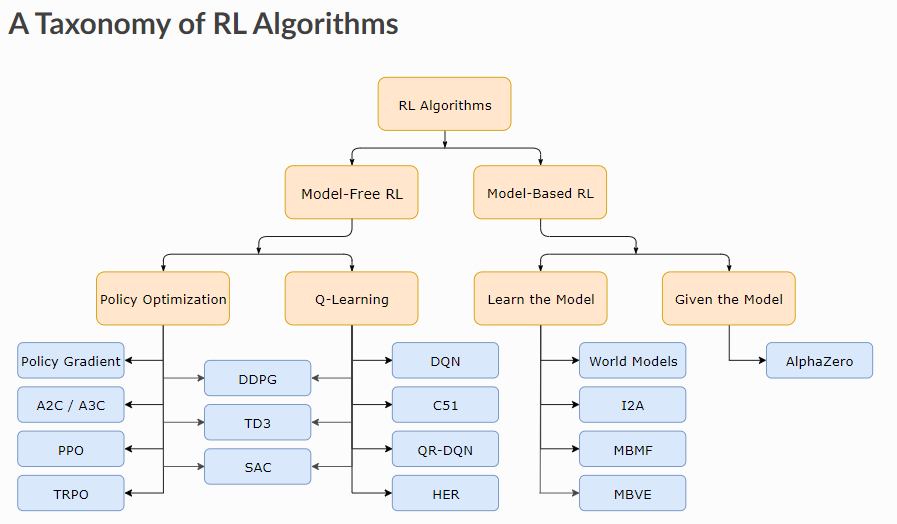

# Model Based RL: Model-based RL involves learning a model of the environment's dynamics to plan actions
# Model Free RL: Model-free RL directly learns a policy or value function without explicit modeling.

### Basic Steps to Develope a RL model
- Import Dependencies
- Load the Environment
- Train a RL model
- Save and Reload the model
- Evaluate and Test the model

## Algorithm that I used in cartpole

- PPO (Proximal Policy Optimization): Here new policy should be not too far from the old policy. For that, ppo uses clipping to avoid too large update.

- DQN (Deep Q Network): It is builds on Fitted Q-Iteration (FQI) and make use of different tricks to stabilize the learning with neural networks: it uses a replay buffer, a target network and gradient clipping.

# 1. Import dependencies

In [ ]:
# Stable Baseline3  is a set of reliable implementations of reinforcement learning algorithms in PyTorch.

!pip install stable-baselines3[extra]

In [ ]:
# OpenAI Gymnasium is an environment for developing and testing learning agents.

!pip install gymnasium

In [ ]:
# import required library

import os
import gymnasium as gym 
from stable_baselines3 import PPO

# stable baseline3 is allow vectorize environment in which agent learn on more than one environment at the same time
from stable_baselines3.common.vec_env import DummyVecEnv
# for test the model performance
from stable_baselines3.common.evaluation import evaluate_policy

import warnings
warnings.filterwarnings("ignore")

# 2. Load Environment

### Types of OpenAI Gym spaces

- Box: n dimensional tensor, range of values e.g, Box(0,1,shape=(3,3))
- Discrete: set of items e.g, Discrete (3)
- Tuple: tuple of other spaces e.g, Box or Discrete
- Dict: Dictionary of spaces e.g, Box or Discrete
- MultiBinary: One hot encoded binary values e.g, MultiBinary(4)
- MultiDiscrete: Multiple discrete values e.g, MultiDiscrete([5,2,2])

In [ ]:
environment_name = "CartPole-v1"

In [ ]:
env = gym.make(environment_name)

### Episodes
- Episodes means one full game within the environment.
- Some environment have  fixed episodes length e.g, CartPole is 200 frames

In [ ]:
episodes = 5

for episode in range(1, episodes + 1):
    state = env.reset()  # initial set of observation
    done = False
    score = 0 
    
    while not done:
        env.render()    # display the environment
        action = env.action_space.sample()
        step_result = env.step(action)
        
        # Unpack the first four elements, ignore the rest
        n_state, reward, done, info, _ = step_result
        score += reward
    
    print('Episode:{} Score:{}'.format(episode, score))

env.close()


### Environment Functions

- env.reset(): reset the env and obtain initial observations
- env.render(): visualise the environment
- env.step(): apply an action to the environment
- env.close(): close down the render frame

In [ ]:
# initial set of observation

env.reset()

In [ ]:
# Action space is '0' or '1'

env.action_space

In [ ]:
# 0-push cart to left, 1-push cart to the right
env.action_space.sample()

In [ ]:
env.observation_space

In [ ]:
# [cart position[-4.8,4.8], cart velocity[-Inf,Inf], pole angle[-24,24], pole angular velocity[-Inf,Inf]]
env.observation_space.sample()

In [ ]:
env.step(1)

### Algorithm used based on action

- Discrete Single Process: DQN
- Discrete Multi Processed: PPO or A2C
- Continuous Single Process: SAC or TD3
- Continuous Multi Processed: PPO or A2C

# 3. Train an RL Model

In [ ]:
log_path=os.path.join('Training','Logs')

In [ ]:
log_path

In [ ]:
env = gym.make(environment_name)
env = DummyVecEnv([lambda: env])
model = PPO('MlpPolicy', env, verbose = 1,tensorboard_log=log_path)

In [ ]:
# PPO??

- Stable Baselines has three policy:
    - MlpPolicy
    - CnnPolicy
    - MultiInputPolicy

### Training Metrics

- Evaluation Metrics:
    - Ep_len_mean: On average how long a particular episodes lasted before done 
    - ep_rew_mean: The average reward that the agent accumulated per episode
- Time Metrics: fps, iteration, time_elapsed, total_timesteps
- Loss Metrics: Entropy_loss, policy_loss, value_loss
- other Metrics: Explained_variance, Learning_rate, n_updates

In [ ]:
model.learn(total_timesteps=20000)

# 4. Save and Reload Model

In [ ]:
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_model')

In [ ]:
model.save(PPO_path)

In [ ]:
PPO_path

In [ ]:
del model

In [ ]:
model = PPO.load(PPO_path, env=env)

In [ ]:
model.learn(total_timesteps=1000)

# 5. Evaluation

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, env, n_eval_episodes=10, render=True)
# return average reward and standard deviation

In [ ]:
env.close()

### CartPole Reward
- Reward for CartPole is calculated as 1 point for every step that the pole remains upright (with a max of 200 steps).
- If the pole is more than 15 degree from vertical of the cart moves more than 2.4 units from center the episode ends.

# 6. Test Model

In [ ]:
episodes = 5
for episode in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action, _ = model.predict(obs) # now using model here
        step_result = env.step(action)
        
        obs, reward, done, info = step_result
        score += reward
    
    print('Episode:{} Score:{}'.format(episode, score))

In [ ]:
env.close()

In [ ]:
obs=env.reset()

In [ ]:
obs

In [ ]:
action, _ = model.predict(obs)

In [ ]:
env.action_space.sample()

In [ ]:
env.step(action)

In [ ]:
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done: 
        print('info', info)
        break

In [ ]:
env.close()

# 7. Viewing Logs in Tensorboard

In [ ]:
training_log_path = os.path.join(log_path, 'PPO_2')

In [ ]:
training_log_path

In [ ]:
# !tensorboard --logdir={training_log_path}

# 8. Adding a callback to the training Stage

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import os

In [ ]:
save_path = os.path.join('Training', 'Saved Models')
log_path = os.path.join('Training', 'Logs')

In [ ]:
env = gym.make(environment_name)
env = DummyVecEnv([lambda: env])

In [ ]:
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=190, verbose=1)
eval_callback = EvalCallback(env, 
                             callback_on_new_best=stop_callback, 
                             eval_freq=10000, 
                             best_model_save_path=save_path, 
                             verbose=1)

In [ ]:
model = PPO('MlpPolicy', env, verbose = 1, tensorboard_log=log_path)

In [ ]:
model.learn(total_timesteps=20000, callback=eval_callback)

In [ ]:
model_path = os.path.join('Training', 'Saved Models', 'best_model')
model = PPO.load(model_path, env=env)

In [ ]:
evaluate_policy(model, env, n_eval_episodes=10, render=True)

In [ ]:
env.close()

# 9. Changing Policies

In [ ]:
# new neural netwok architecture define
net_arch=[dict(pi=[128, 128, 128, 128], vf=[128, 128, 128, 128])]

In [ ]:
model = PPO('MlpPolicy', env, verbose = 1, tensorboard_log=log_path, policy_kwargs={'net_arch': net_arch})

In [ ]:
model.learn(total_timesteps=20000, callback=eval_callback)

# 10. Using an Alternate Algorithm

In [ ]:
from stable_baselines3 import DQN

In [ ]:
model = DQN('MlpPolicy', env, verbose = 1, tensorboard_log=log_path)

In [ ]:
model.learn(total_timesteps=20000, callback=eval_callback)

In [ ]:
dqn_path = os.path.join('Training', 'Saved Models', 'DQN_model')

In [ ]:
model.save(dqn_path)

In [ ]:
model = DQN.load(dqn_path, env=env)

In [ ]:
evaluate_policy(model, env, n_eval_episodes=10, render=True)

In [ ]:
env.close()